# PAMAP2 ➜ TS2Vec ➜ Fractal‑SSL  
An interactive, step‑by‑step Jupyter workflow.

**Sections**
1. Inspect & preprocess PAMAP2
2. Pre‑train a TS2Vec backbone
3. Enhance with Fractal‑SSL


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0  Setup

In [2]:
#  Run once per environment
!pip install -q torch==2.3.0 ts2vec pandas scikit-learn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1  Imports & paths

In [3]:
import os, glob, json, math, random, itertools, pickle
from pathlib import Path
import numpy as np, pandas as pd, torch
from tqdm import tqdm

from ts2vec import TS2Vec

RAW_ROOT   = Path('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset').expanduser()   # <- edit if needed
CACHE_ROOT = Path('/content/drive/MyDrive/FractalSSL_backup/cache')
CACHE_ROOT.mkdir(exist_ok=True)


In [4]:

RAW_ROOT

PosixPath('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset')

### Helper to read a single PAMAP2 `.dat` file

In [18]:
COLS = [
    "timestamp", "activity_id", "heart_rate",
    # IMU columns...
]  # shortened for brevity – full list in spec

def load_dat(path: Path, cols=COLS, downsample_hr=True):
    """Returns a DataFrame (100 Hz) with NaNs handled."""
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = cols + [f'col_{i}' for i in range(len(df.columns)-len(cols))]

    # Optional: down‑sample HR (original 9 Hz) – simple forward‑fill
    if downsample_hr:
        df['heart_rate'].replace(-1, np.nan, inplace=True)
        df['heart_rate'].interpolate(method='linear', limit_direction='both', inplace=True)

    # Normalise sensor channels (z‑score per column)
    sensor_cols = df.columns.drop(['timestamp', 'activity_id'])
    df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()
    return df


### Load & peek at Subject 101

In [11]:
print('First 5 .dat files I see:')
for p in list(RAW_ROOT.rglob('*.dat'))[:5]:
    print(' •', p.relative_to(RAW_ROOT))

First 5 .dat files I see:
 • Protocol/subject101.dat
 • Protocol/subject102.dat
 • Protocol/subject103.dat
 • Protocol/subject104.dat
 • Protocol/subject105.dat


In [12]:
sample_path = next(RAW_ROOT.glob('*Protocol/subject101.dat'))
df101 = load_dat(sample_path)
df101.head()


/tmp/ipython-input-10-981279570.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-10-981279570.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,timestamp,activity_id,heart_rate,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,8.38,0,-0.839332,-1.965332,0.898811,0.446885,0.030369,0.895952,0.471171,-0.064588,...,0.008444,0.014729,-0.017610,-0.401004,-1.138542,-2.322759,NaN,NaN,NaN,NaN
1,8.39,0,-0.839332,-1.965332,0.869927,0.440123,0.075092,0.888978,0.430758,0.020714,...,-0.006492,-0.008282,-0.007561,-0.348879,-1.136321,-2.335681,NaN,NaN,NaN,NaN
2,8.40,0,-0.839332,-1.965332,0.899021,0.446949,0.041749,0.874937,0.428003,0.047642,...,0.003137,-0.000352,0.004828,-0.383407,-1.153368,-2.331433,NaN,NaN,NaN,NaN
3,8.41,0,-0.839332,-1.965332,0.852074,0.432989,0.074625,0.879650,0.427961,0.047633,...,0.003298,-0.034234,-0.001454,-0.370695,-1.132127,-2.331288,NaN,NaN,NaN,NaN
4,8.42,0,-0.839332,-1.965332,0.876366,0.491239,0.086386,0.863274,0.439690,0.056590,...,0.012859,-0.024295,-0.009347,-0.413875,-1.152522,-2.327013,NaN,NaN,NaN,NaN


### Cache all subjects (optional, ~1 GB)

In [13]:
for path in tqdm(list(RAW_ROOT.rglob('*.dat')), desc='Caching'):
    subj = path.stem.split('.')[0]
    out = CACHE_ROOT / f'{subj}.pkl'
    if out.exists():
        continue
    load_dat(path).to_pickle(out)
print('Done ✅')


Caching: 100%|██████████| 8/8 [00:00<00:00, 4067.70it/s]

Done ✅


## 2  TS2Vec pre‑training

In [ ]:
%pip uninstall -y ts2vec
%pip install git+https://github.com/yuezhihan/ts2vec.git@main


Found existing installation: ts2vec 0.1
Uninstalling ts2vec-0.1:
  Successfully uninstalled ts2vec-0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/yuezhihan/ts2vec.git (to revision main) to /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Running command git clone --filter=blob:none --quiet https://github.com/yuezhihan/ts2vec.git /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Resolved https://github.com/yuezhihan/ts2vec.git to commit b0088e14a99706c05451316dc6db8d3da9351163
ERROR: git+https://github.com/yuezhihan/ts2vec.git@main does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install ts2vec

  Using cached ts2vec-0.1-py3-none-any.whl.metadata (53 bytes)
Using cached ts2vec-0.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
def window_iter(data, win_sec=5, stride_sec=2, fs=100):
    win = win_sec * fs
    stride = stride_sec * fs
    for start in range(0, len(data) - win, stride):
        yield data[start:start+win].values


In [12]:
class PAMAP2Windows(torch.utils.data.Dataset):
    def __init__(self, cache_root=CACHE_ROOT):
        self.paths = list(cache_root.glob('subject*.pkl'))
        self.windows = []
        for p in self.paths:
            # DON’T call .to_numpy() here
            df = pd.read_pickle(p).drop(columns=['timestamp', 'activity_id'])
            self.windows += list(window_iter(df))
    def __len__(self): return len(self.windows)
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx]).float()


dataset = PAMAP2Windows()
print('Total windows:', len(dataset))


Total windows: 14344


In [13]:
import numpy as np, gc, torch

# ── Build a single 3-D array (may take ~1-2 GB of RAM)
all_windows = np.stack(dataset.windows, axis=0).astype(np.float32)
print('Stacked:', all_windows.shape, f'≈ {all_windows.nbytes/1e9:.2f} GB')

# free the Python list; we only need the big array from here on
del dataset
gc.collect()

Stacked: (14344, 500, 52) ≈ 1.49 GB


8

In [8]:
import torch
#torch.backends.mps.is_available()
# → True  ✅
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'


# Colab → use the CUDA device if the notebook is attached to a GPU runtime,
# otherwise fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)



Using device: cuda


In [14]:
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,   # hyper-params live in the constructor
    lr=1e-3
)

enc.fit(all_windows, n_epochs=20, verbose=True)
enc.save('ts2vec_backbone.pt')


Epoch #0: loss=6.682124648775373
Epoch #1: loss=3.38065528018134
Epoch #2: loss=2.966054801430021
Epoch #3: loss=2.5879269199711934
Epoch #4: loss=2.287498559270586
Epoch #5: loss=2.094871482678822
Epoch #6: loss=1.9605490160839898
Epoch #7: loss=1.841879386987005
Epoch #8: loss=1.705591184752328
Epoch #9: loss=1.6370791239397866
Epoch #10: loss=1.6358701011964254
Epoch #11: loss=1.56590550499303
Epoch #12: loss=1.516149110027722
Epoch #13: loss=1.4603432608502251
Epoch #14: loss=1.308795622416905
Epoch #15: loss=1.3436941759926933
Epoch #16: loss=1.2931537617530142
Epoch #17: loss=1.241940224809306
Epoch #18: loss=1.2706349353705133
Epoch #19: loss=1.1982874838369233


In [15]:
# save the backbone for later use
save_path = '/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt'
enc.save(save_path)


In [16]:
# load the backbone
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,
    lr=1e-3
)
enc.load('/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt')

In [ ]:
# Project a random batch and inspect shape
batch = torch.from_numpy(all_windows[np.random.choice(len(all_windows), 32)]).float().to(device)
embeddings = enc(batch)
print('Batch shape:', batch.shape, '→ Embeddings shape:', embeddings.shape)



In [19]:
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, torch, random
from pathlib import Path

class PAMAP2LabeledWindows(Dataset):
    def __init__(self, raw_root, win_sec=5, stride_sec=2, fs=100):
        self.X, self.y = [], []
        win, stride = win_sec*fs, stride_sec*fs
        for f in Path(raw_root).rglob('subject*.dat'):
            df = load_dat(f)                         # reuse helper
            data = df.drop(columns=['timestamp']).to_numpy(dtype=np.float32)
            acts = df['activity_id'].to_numpy()
            for start in range(0, len(df)-win, stride):
                end = start+win
                self.X.append(data[start:end, 1:])   # sensor channels
                # majority label in the window:
                label = np.bincount(acts[start:end]).argmax()
                self.y.append(label)
        self.X, self.y = np.stack(self.X), np.array(self.y, dtype=np.int64)

    def __len__(self):  return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

labeled_ds = PAMAP2LabeledWindows(RAW_ROOT)
print('Windows:', len(labeled_ds), 'Shape:', labeled_ds[0][0].shape)


/tmp/ipython-input-18-981279570.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-18-981279570.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Windows: 19224 Shape: torch.Size([500, 52])


In [20]:

with torch.no_grad():                     # optional – encode() already uses no_grad
    feats = enc.encode(
        labeled_ds.X.astype(np.float32)   # pass a NumPy array, not a tensor
    )                                     # (N, L, D)

# keep only the last time-step representation
feats = feats[:, -1, :]                   # (N, D)
labels = labeled_ds.y



In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

Xtr, Xte, ytr, yte = train_test_split(
    feats, labels, test_size=0.2, stratify=labels, random_state=42)

clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs')
clf.fit(Xtr, ytr)

pred = clf.predict(Xte)
print(classification_report(yte, pred, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.517     0.779     0.621      1121
           1      0.981     0.813     0.890       193
           2      0.943     0.811     0.872       185
           3      0.821     0.795     0.807       190
           4      0.722     0.744     0.733       238
           5      0.808     0.602     0.690        98
           6      0.949     0.794     0.865       165
           7      0.688     0.561     0.618       189
           9      0.000     0.000     0.000        83
          10      0.929     0.887     0.908       310
          11      0.000     0.000     0.000        54
          12      0.554     0.350     0.429       117
          13      0.588     0.381     0.462       105
          16      0.689     0.583     0.632       175
          17      0.848     0.770     0.807       239
          18      0.750     0.570     0.648       100
          19      0.592     0.310     0.407       187
          20      0.718    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


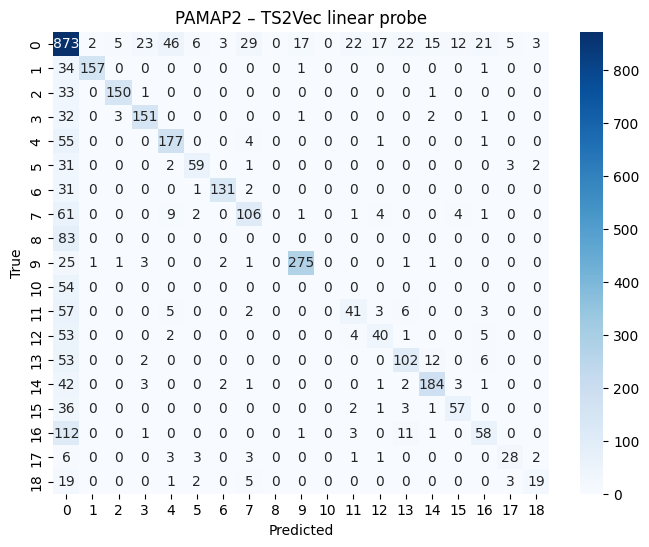

In [22]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(yte, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


In [25]:
from sklearn.utils.class_weight import compute_class_weight

# compute balanced class weights
classes = np.unique(ytr)
weights = compute_class_weight('balanced', classes=classes, y=ytr)
class_w = dict(zip(classes, weights))

clf_bal = LogisticRegression(
    max_iter=1000,
    class_weight=class_w,          # <–
    solver='lbfgs'
).fit(Xtr, ytr)

print(classification_report(yte, clf_bal.predict(Xte), digits=3))


              precision    recall  f1-score   support

           0      0.844     0.266     0.404      1121
           1      0.915     0.834     0.873       193
           2      0.899     0.822     0.859       185
           3      0.743     0.837     0.787       190
           4      0.695     0.803     0.745       238
           5      0.622     0.571     0.596        98
           6      0.838     0.812     0.825       165
           7      0.568     0.661     0.611       189
           9      0.000     0.000     0.000        83
          10      0.853     0.900     0.876       310
          11      0.077     1.000     0.144        54
          12      0.435     0.598     0.504       117
          13      0.367     0.524     0.431       105
          16      0.592     0.680     0.633       175
          17      0.823     0.795     0.809       239
          18      0.492     0.630     0.553       100
          19      0.490     0.406     0.444       187
          20      0.457    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 3  Fractal‑SSL fine‑tuning

In [26]:
class FractalViewGenerator:
    """Produces recursively smaller crops of the same window."""
    def __init__(self, levels=4):
        self.levels = levels
    def __call__(self, ts):
        L = ts.shape[0]
        views = []
        for i in range(self.levels):
            frac = 1 / (2 ** i)
            win = int(L * frac)
            start = random.randint(0, L - win)
            views.append(ts[start:start+win])
        return views
gen = FractalViewGenerator(levels=4)

ts = torch.from_numpy(all_windows[0])      # one window, shape (L, C)
views = gen(ts)                            # list of 4 tensors

print([v.shape for v in views])


[torch.Size([500, 52]), torch.Size([250, 52]), torch.Size([125, 52]), torch.Size([62, 52])]


In [41]:
def nt_xent(reps: torch.Tensor, batch_size: int, n_views: int, T: float) -> torch.Tensor:
    """
    reps      : (B * n_views, D) ℓ2-normalised
    returns   : scalar loss
    """
    N   = reps.size(0)
    sim = reps @ reps.T / T                       # cosine sim over temperature

    # zero out self-similarities (i == j)
    sim.fill_diagonal_(-1e4)

    # positive index: for each view i, its twin is (i ± 1) within the same sample
    view_idx   = torch.arange(N, device=reps.device)
    pos_index  = view_idx ^ 1                     # flips last bit: 0↔1, 2↔3, …
    loss       = torch.nn.functional.cross_entropy(sim, pos_index)

    return loss


In [40]:
import torch, random, numpy as np
from typing import List, Tuple

class FractalViewGenerator:
    def __init__(self, levels: int = 4):
        self.levels = levels
    def __call__(self, ts: torch.Tensor) -> Tuple[List[torch.Tensor], List[int]]:
        L, views, lens = ts.size(0), [], []
        for i in range(self.levels):
            win   = int(L / 2 ** i)
            start = random.randint(0, L - win)
            crop  = ts[start:start + win]
            views.append(crop)
            lens.append(win)
        return views, lens

class FractalSSL(torch.nn.Module):
    def __init__(self, backbone, proj_dim=128, levels=4,
                 temperature=0.1, freeze_backbone=True):
        super().__init__()
        self.backbone, self.levels, self.temperature = backbone, levels, temperature
        self.view_gen = FractalViewGenerator(levels)

        # ---- determine channels & device from first param -------------------
        first_w  = next(backbone.net.parameters()) if hasattr(backbone, "net") \
                   else next(backbone.parameters())
        self._in_channels = first_w.shape[1] if first_w.ndim >= 2 else first_w.shape[0]

        # ---- optional freezing ---------------------------------------------
        if freeze_backbone and hasattr(backbone, "net"):
            for p in backbone.net.parameters():
                p.requires_grad = False

        # ---- infer latent dimension ----------------------------------------
        with torch.no_grad():
            dummy = np.zeros((1, 8, self._in_channels), dtype='float32')
            latent_dim = backbone.encode(dummy).shape[-1]

        self.proj = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, proj_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(proj_dim, proj_dim)
        )

    # ---------- tiny helper so we never forget the NumPy conversion ----------
    def _ts2vec_encode(self, x: torch.Tensor) -> torch.Tensor:
      """
      Wrap TS2Vec.encode(): accepts (N,L,C) tensor, returns tensor on same device
      no matter whether the fork outputs NumPy or PyTorch.
      """
      dev   = x.device
      out   = self.backbone.encode(x.detach().cpu().numpy())  # NumPy in → ??? out
      feats = torch.as_tensor(out, device=dev, dtype=torch.float32)  # <── FIX
      return feats

    # ------------------------------------------------------------------------
    def forward(self, ts_batch: torch.Tensor) -> torch.Tensor:
        device, views, lens = ts_batch.device, [], []
        for ts in ts_batch:
            sub, ln = self.view_gen(ts)
            views += [v.to(device) for v in sub]
            lens  += ln

        padded = torch.nn.utils.rnn.pad_sequence(views, batch_first=True)
        mask   = (torch.arange(padded.size(1), device=device)[None, :]
                 < torch.tensor(lens, device=device)[:, None])

        emb = self._ts2vec_encode(padded)          # (N,T,D) on same device
        emb = (emb * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)

        proj = torch.nn.functional.normalize(self.proj(emb), dim=-1)
        return proj



In [42]:
N_VIEWS      = 2          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=False   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)


In [43]:
BATCH_SIZE = 64      #
N_STEPS    = 1000    # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(all_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(all_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")


step   50 | NT-Xent loss = 0.6788
step  100 | NT-Xent loss = 0.4826
step  150 | NT-Xent loss = 0.6063
step  200 | NT-Xent loss = 0.5018
step  250 | NT-Xent loss = 0.4496
step  300 | NT-Xent loss = 0.4412
step  350 | NT-Xent loss = 0.5560
step  400 | NT-Xent loss = 0.4563
step  450 | NT-Xent loss = 0.6461
step  500 | NT-Xent loss = 0.5705
step  550 | NT-Xent loss = 0.2984
step  600 | NT-Xent loss = 0.1930
step  650 | NT-Xent loss = 0.4171
step  700 | NT-Xent loss = 0.8395
step  750 | NT-Xent loss = 0.4910
step  800 | NT-Xent loss = 0.4983
step  850 | NT-Xent loss = 0.4150
step  900 | NT-Xent loss = 0.5662
step  950 | NT-Xent loss = 0.4166
step 1000 | NT-Xent loss = 0.6673


In [47]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FractalSSL_backup/models/fractal_ts2vec.pt')
print('Saved to fractal_ts2vec.pt')

Saved to fractal_ts2vec.pt


In [50]:

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_all = embed_windows(model, labeled_ds.X.astype(np.float32))           # (N,D)
print("embeddings:", emb_all.shape)


embeddings: (19224, 320)


In [51]:
labels = labeled_ds.y
print('labels:', labels.shape)

labels: (19224,)


In [52]:




# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_tr, X_te, y_tr, y_te = train_test_split(emb_all, labels, stratify=labels, test_size=0.2, random_state=42)
clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs')
clf.fit(Xtr, ytr)

print(classification_report(y_te, clf.predict(X_te), digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.545     0.806     0.650      1121
           1      0.940     0.813     0.872       193
           2      0.719     0.762     0.740       185
           3      0.816     0.605     0.695       190
           4      0.787     0.824     0.805       238
           5      0.955     0.643     0.768        98
           6      0.992     0.776     0.871       165
           7      0.945     0.550     0.696       189
           9      0.000     0.000     0.000        83
          10      0.920     0.890     0.905       310
          11      0.000     0.000     0.000        54
          12      0.663     0.538     0.594       117
          13      0.857     0.457     0.596       105
          16      0.817     0.537     0.648       175
          17      0.854     0.833     0.843       239
          18      0.855     0.530     0.654       100
          19      0.519     0.503     0.511       187
          20      0.705    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
